<a href="https://colab.research.google.com/github/Richardjmorton/colab/blob/master/Bayesian_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow_probability as tfp

import numpy as np
import matplotlib.pyplot as plt


tfpl = tfp.layers

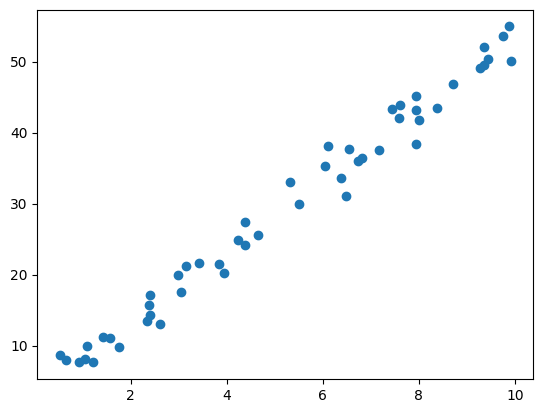

In [2]:
N = 50
x = np.random.uniform(0, 10, N)

alpha = 3
beta = 5
y = alpha + beta*x

rng = np.random.default_rng(123)

noise = rng.normal(loc=0,scale=2, size=N)

y += noise

x = x[:, np.newaxis]
y = y[:, np.newaxis]

plt.plot(x, y, 'o')

In [3]:
model = Sequential([
    tf.keras.layers.Dense(2),
    tfpl.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t[...,:1],
                                                               scale=1e-3+tf.math.softplus(0.05*t[...,1:])))
])

In [4]:
def nll(y_true, y_pred):
  return - y_pred.log_prob(y_true)

In [43]:
model.compile(loss=nll, optimizer=tf.optimizers.Adam(learning_rate=0.01))
model.fit(x, y, epochs=1000, verbose=False)

In [12]:
x_test = np.arange(0,10,0.5)

y_pred = model(x_test[:,np.newaxis])

In [13]:
#OLS estimates
X= np.vstack([np.ones(N), x[:,0]])
X = X.T
theta = np.linalg.inv(X.T@X)@(X.T@y[:,0])
print('Paramter estimates', theta)

y_pred_ols = theta[0]+theta[1]*x

p=2
var_eps = 1/(N-p-1)*np.sum((y_pred_ols-y)**2)
X_test = np.vstack([np.ones(len(x_test)), x_test])
X_test = X_test.T
pred_ints = np.eye(len(x)) + (X@np.linalg.inv(X.T@X))@X.T
pred_ints = np.sqrt( var_eps*np.diag(pred_ints) )

Paramter estimates [3.37696522 4.98754051]


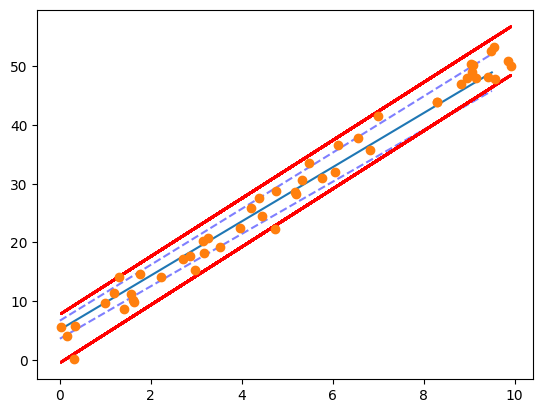

In [95]:
pred_err = y_pred.mean()+ 2.*y_pred.stddev()
pred_err_low = y_pred.mean()- 2.*y_pred.stddev()

y_pred_ols = theta[0]+theta[1]*x
pred_err_ols = y_pred_ols+ 2.*pred_ints
pred_err_low_ols = y_pred_ols- 2.*pred_ints

plt.plot(x_test, y_pred.mean())
plt.plot(x_test, pred_err,'--', color='blue', alpha=0.5)
plt.plot(x_test, pred_err_low,'--', color='blue', alpha=0.5)

plt.plot(x, pred_err_ols,'--', color='red', alpha=0.5)
plt.plot(x, pred_err_low_ols,'--', color='red', alpha=0.5)

plt.plot(x, y, 'o')

In [30]:
model.weights

[<tf.Variable 'dense_3/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.99327874]], dtype=float32)>,
 <tf.Variable 'dense_3/bias:0' shape=(1,) dtype=float32, numpy=array([0.10989284], dtype=float32)>]

In [7]:

def prior(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size
  return lambda t: tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(n, dtype=dtype), scale=1),
                                                 reinterpreted_batch_ndims=1)

In [8]:
def posterior(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size
  return Sequential([
      tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
      tfpl.IndependentNormal(n)
  ])

In [119]:
model = Sequential([
    tfpl.DenseVariational(2, posterior, prior, kl_weight=1/N),
    tfpl.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t[...,:1],
                                                               scale=tf.math.softplus(0.05*t[...,1:])))
])

In [113]:
model.compile(loss=nll, optimizer=tf.optimizers.RMSprop(learning_rate=0.005))
model.fit(x, y, epochs=1000, verbose=False)

In [114]:
yhats = [model(x_test[:,np.newaxis]) for _ in range(100)]

In [115]:
y_mean = []
y_stds = []
for yhat in yhats:
  y_mean.append(yhat.mean())
  y_stds.append(yhat.stddev())


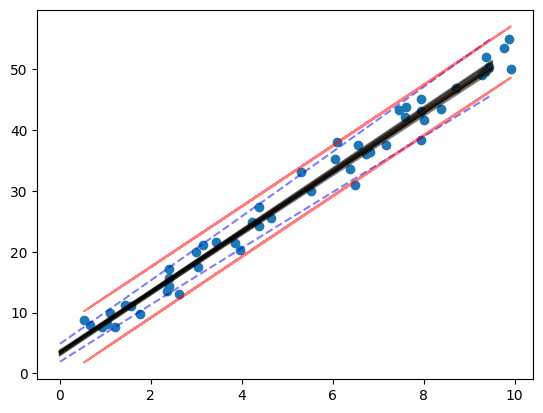

In [117]:
ymean = np.array(y_mean)
ystds = np.array(y_stds)
pred_err = ymean.mean(axis=0)+ 2.*ystds.mean(axis=0)
pred_err_low = ymean.mean(axis=0)- 2.*ystds.mean(axis=0)

y_pred_ols = theta[0]+theta[1]*x
pred_err_ols = y_pred_ols[:,0]+ 2.*pred_ints
pred_err_low_ols = y_pred_ols[:,0]- 2.*pred_ints

plt.plot(x, y, 'o')

plt.plot(x_test, ymean.mean(axis=0))
plt.plot(x_test, ymean[0:10,:,0].T, color='black', alpha=0.5)
plt.plot(x_test, pred_err,'--', color='blue', alpha=0.5)
plt.plot(x_test, pred_err_low,'--', color='blue', alpha=0.5)

plt.plot(x, pred_err_ols,'--', color='red', alpha=0.5)
_= plt.plot(x, pred_err_low_ols,'--', color='red', alpha=0.5)



In [118]:
model.weights

[<tf.Variable 'dense_variational_9/posterior/constant:0' shape=(8,) dtype=float32, numpy=
 array([ 4.956579  ,  4.521702  ,  3.406387  ,  1.5828413 , -2.8321023 ,
        -0.29181448, -1.3647959 ,  0.51663965], dtype=float32)>]